In [1]:
import torch
import torch.nn as nn
from utils.display import *

In [2]:
def np_now(tensor) : return tensor.detach().cpu().numpy()

In [3]:
def clamp(x, lo=0, hi=1) : return max(lo, min(hi, x))

In [4]:
class PruneMask() :
    def __init__(self, layer, prune_rnn_input) :
        self.mask = []
        self.p_idx = [0]
        self.total_params = 0
        self.pruned_params = 0
        self.split_size = 0
        self.init_mask(layer, prune_rnn_input)
    
    
    def init_mask(self, layer, prune_rnn_input) :
        # Determine the layer type and 
        # num matrix splits if rnn 
        layer_type = str(layer).split('(')[0]
        splits = {'Linear': 1, 'GRU': 3, 'LSTM': 4}
        
        # Organise the num and indices of layer parameters
        # Dense will have one index and rnns two (if pruning input)
        if layer_type != 'Linear' : 
            self.p_idx = [0, 1] if prune_rnn_input else [1]
        
        # Get list of parameters from layers
        params = self.get_params(layer)
        
        # For each param matrix in this layer, create a mask
        for W in params :
            self.mask += [torch.ones_like(W)]
            self.total_params += W.size(0) * W.size(1)
        
        # Need a split size for mask_from_matrix() later on
        self.split_size = self.mask[0].size(0) // splits[layer_type]

    
    def get_params(self, layer) :
        params = []
        for idx in self.p_idx : 
            params += [list(layer.parameters())[idx].data]
        return params
    
    
    def update_mask(self, layer, z) :
        params = self.get_params(layer)
        for i, W in enumerate(params) :
             self.mask[i] = self.mask_from_matrix(W, z)
        self.update_prune_count()
    
    
    def apply_mask(self, layer) :
        params = self.get_params(layer)
        for M, W in zip(self.mask, params) : W *= M

    
    def mask_from_matrix(self, W, z) :    
        # Split into gate matrices (or not)
        W_split = torch.split(W, self.split_size)
        
        M = []
        # Loop through splits 
        for W in W_split :
            # Sort the magnitudes
            W_abs = torch.abs(W)
            sorted_abs, _ = torch.sort(W_abs.view(-1))

            # Pick k (num weights to zero) 
            k = int(W.size(0) * W.size(1) * z) 
            threshold = sorted_abs[k]
            
            # Create the mask
            M += [(W_abs >= threshold).float()]

        return torch.cat(M)
    
    
    def update_prune_count(self) :
        self.pruned_params = 0
        for M in self.mask :
            self.pruned_params += int(np_now((M - 1).sum() * -1))

In [5]:
class Pruner() :
    def __init__(self, layers, start_prune, prune_steps, target_sparsity, 
                 prune_rnn_input=True, prune_every=500) :
        self.z = 0 # Objects sparsity @ time t
        self.t_0 = start_prune
        self.S = prune_steps
        self.Z = target_sparsity
        self.prune_every = prune_every
        self.num_pruned = 0
        self.total_params = 0
        self.masks = []
        for layer in layers : 
            self.masks += [PruneMask(layer, prune_rnn_input)]
        self.count_total_params()
        
        
    def update_sparsity(self, t) :
        t = np_now(t)[0]
        z = self.Z * (1 - (1 - (t - self.t_0) / self.S)**3)
        self.z = clamp(z, 0, self.Z)
        return t 
    
    
    def prune(self, layers, t) :
        
        t = self.update_sparsity(t)
        
        for (l, m) in zip(layers, self.masks) :
            if self.prune_or_not(t) : m.update_mask(l, self.z)
            if self.apply_or_not(t) : m.apply_mask(l)
        self.count_num_pruned()
         
    
    def prune_or_not(self, t) :
        return True if t % self.prune_every == 0 and t > self.t_0 else False
            
            
    def apply_or_not(self, t) :
        return True if t >= self.t_0 else False
    
    
    def restart(self, layers, t) :
        # In case training is stopped
        _ = self.update_sparsity(t)
        for (l, m) in zip(layers, self.masks) :
            m.update_mask(l, self.z)
            
            
    def count_num_pruned(self) :
        self.num_pruned = 0
        for m in self.masks : 
            self.num_pruned += m.pruned_params
            
            
    def count_total_params(self) :
        for m in self.masks : 
            self.total_params += m.total_params

In [6]:
class Model(nn.Module) :
    def __init__(self, in_size, model_size, start_prune=1000, prune_steps=200_000, 
                 sparsity_target=0.98) :
        super().__init__()
        # Model Layers
        self.rnn = nn.GRU(in_size, model_size)
        self.fc = nn.Linear(model_size, model_size)
        self.t = nn.Parameter(torch.zeros(1), requires_grad=False)
        # Model Pruner
        self.layers2prune = [self.rnn, self.fc]
        self.pruner = Pruner(self.layers2prune, start_prune, 
                             prune_steps, sparsity_target )
        num_params(self)
        
    def forward(self) :
        
#         h = torch.ones(1, 2)
#         x = self.rnn(x, h)
#         x = self.fc(x)
        
        self.prune()
        self.step()
        
        return True 
    
    def step(self) :
        self.t += 1
    
    def prune(self) :
        self.pruner.prune(self.layers2prune, self.t)
        
    def restart_pruner(self) :
        self.pruner.restart(self.layer2prune, self.t)

In [7]:
in_size = 128
model_size = 512
start_prune = 10
prune_steps = 20000
sparsity_target = 0.9375
model = Model(in_size, model_size, start_prune, prune_steps, sparsity_target)

Trainable Parameters: 1.249 million


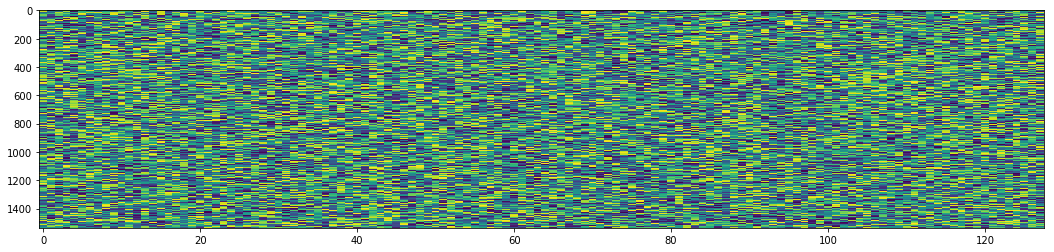

196608 torch.Size([1536, 128])


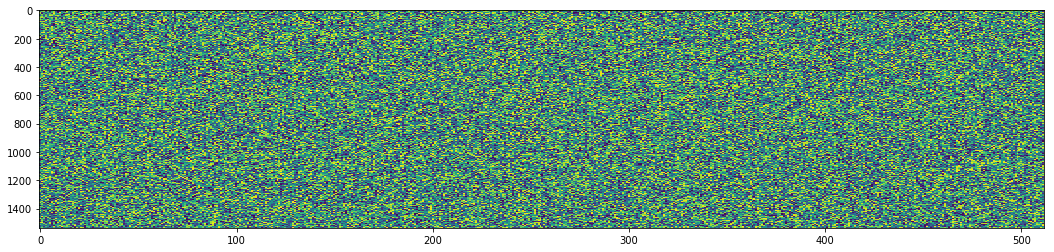

786432 torch.Size([1536, 512])


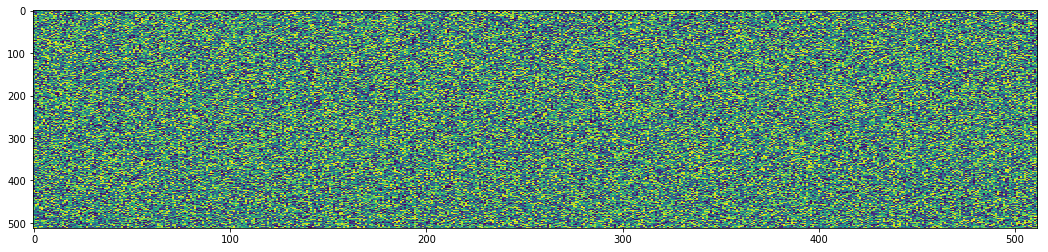

262144 torch.Size([512, 512])


In [8]:
param_idx = [1, 2, 5]
for idx in param_idx :
    W = list(model.parameters())[idx].data
    plot_spec(W)
    print(W.size(0) * W.size(1), W.shape)

In [9]:
sparsity = []
pruned_params = []
num_steps = start_prune + prune_steps + 1000
for step in range(num_steps) :
    model()
    sparsity += [model.pruner.z]
    pruned_params += [model.pruner.num_pruned]
    if step % 100 == 0 : stream('%i/%i', (step, num_steps))

21000/21010

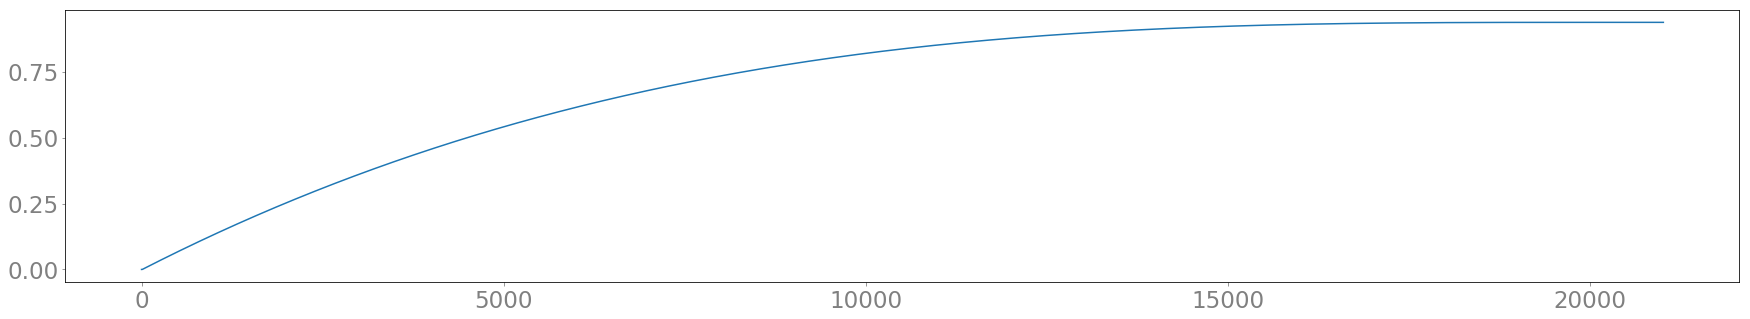

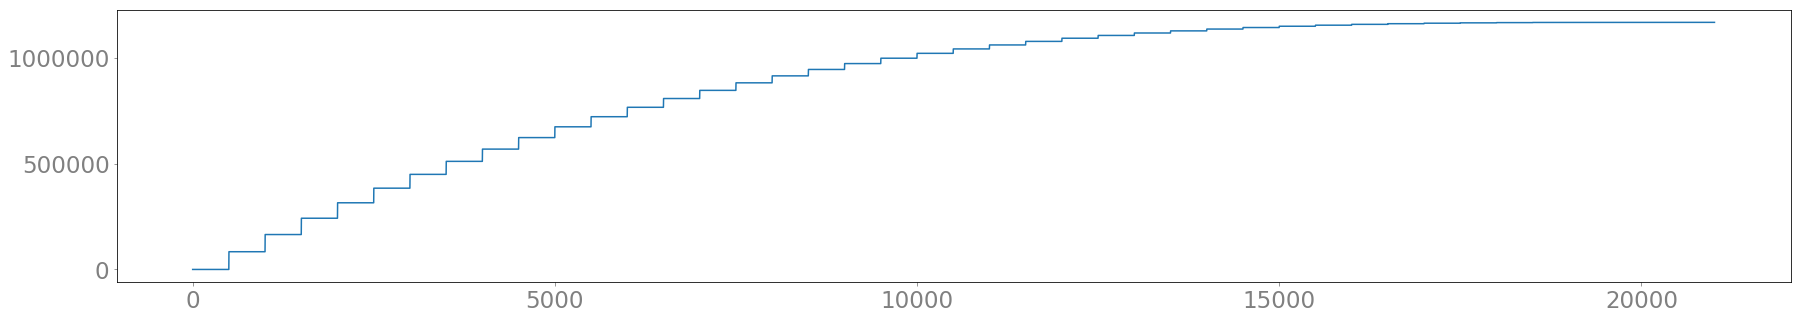

In [10]:
plot(sparsity)
plot(pruned_params)

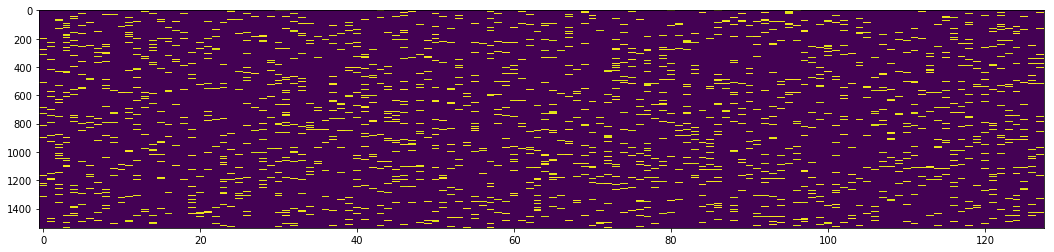

196608 torch.Size([1536, 128])


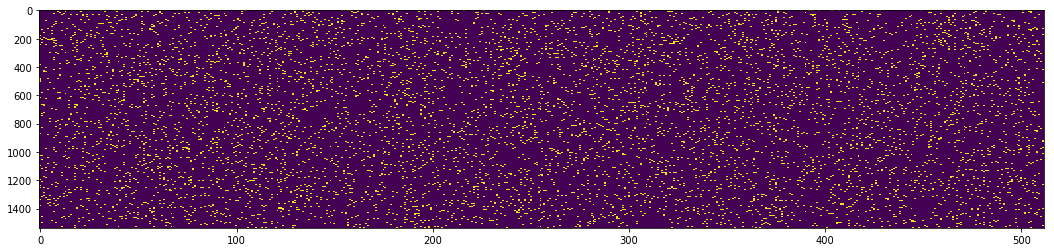

786432 torch.Size([1536, 512])


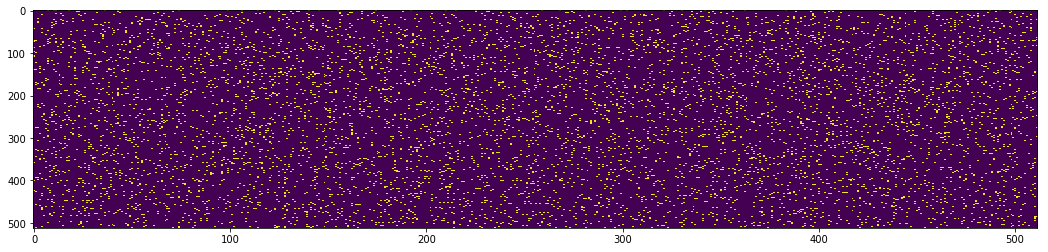

262144 torch.Size([512, 512])


In [11]:
param_idx = [1, 2, 5]
for idx in param_idx :
    W = list(model.parameters())[idx].data
    plot_spec(torch.abs(W))
    print(W.size(0) * W.size(1), W.shape)

In [12]:
model.pruner.Z, model.pruner.z

(0.9375, 0.9375)

In [13]:
model.pruner.num_pruned, model.pruner.total_params, 

(1167360, 1245184)

In [14]:
model.pruner.num_pruned / model.pruner.total_params

0.9375

In [15]:
model.pruner.total_params - model.pruner.num_pruned

77824

In [16]:
model = Model(in_size=1, model_size=2)
model.t += 44_000
model.state_dict()

Trainable Parameters: 0.000 million


OrderedDict([('t', tensor([44000.])), ('rnn.weight_ih_l0', tensor([[ 0.5376],
                      [-0.2343],
                      [-0.5191],
                      [-0.4536],
                      [-0.6217],
                      [ 0.2389]])), ('rnn.weight_hh_l0',
              tensor([[-0.0653, -0.0993],
                      [ 0.4324, -0.4442],
                      [ 0.2594,  0.0243],
                      [-0.5932,  0.1905],
                      [-0.2087,  0.0661],
                      [-0.4895,  0.2997]])), ('rnn.bias_ih_l0',
              tensor([-0.0783, -0.6947,  0.3538, -0.4331,  0.3925, -0.3648])), ('rnn.bias_hh_l0',
              tensor([ 0.0118, -0.3718, -0.5706,  0.3553, -0.4856, -0.6507])), ('fc.weight',
              tensor([[-0.5647, -0.1977],
                      [ 0.4500,  0.6082]])), ('fc.bias',
              tensor([-0.6405, -0.0204]))])

In [17]:
model.prune()
model.pruner.z

0.5059381075

In [18]:
model.state_dict()

OrderedDict([('t', tensor([44000.])), ('rnn.weight_ih_l0', tensor([[ 0.5376],
                      [-0.0000],
                      [-0.5191],
                      [-0.0000],
                      [-0.6217],
                      [ 0.0000]])), ('rnn.weight_hh_l0',
              tensor([[-0.0000, -0.0000],
                      [ 0.4324, -0.4442],
                      [ 0.2594,  0.0000],
                      [-0.5932,  0.0000],
                      [-0.0000,  0.0000],
                      [-0.4895,  0.2997]])), ('rnn.bias_ih_l0',
              tensor([-0.0783, -0.6947,  0.3538, -0.4331,  0.3925, -0.3648])), ('rnn.bias_hh_l0',
              tensor([ 0.0118, -0.3718, -0.5706,  0.3553, -0.4856, -0.6507])), ('fc.weight',
              tensor([[-0.5647, -0.0000],
                      [ 0.0000,  0.6082]])), ('fc.bias',
              tensor([-0.6405, -0.0204]))])